In [14]:
import nglview
import os
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
import random

_ColormakerRegistry()

In [2]:
DNA = open("SARS-CoV-2-Sequence.txt") # Load Genome sequence
DNA = DNA.read()
for s in " \n0123456789":
    DNA = DNA.replace(s, "")

DNA = DNA.upper()
print("Length of SARS-CoV-2 Genome: {}".format(len(DNA)))

Length of SARS-CoV-2 Genome: 29903


In [3]:
#Asn or Asp / B	AAU, AAC; GAU, GAC
#Gln or Glu / Z	CAA, CAG; GAA, GAG
#START	AUG  ------ Duplicate Values in Talbe

table = open("DNA-Genome-Table.txt")   # Load Genome Conversion Table
table = table.read().strip()
dec = {}
for t in table.split("\n"):
    k, v = t.split("\x09")
    k = k.replace("STOP", "#")
    if "/" in k:
        k = k.split("/")[-1].strip()
    v = v.replace(",", "").replace(";","").replace("U", "T").split()
    for vv in v:
        dec[vv] = k

In [11]:
def translation(x):
    amino = []
    for r in range(0, len(x)-2, 3):
        condon = x[r:3+r]
        for ii in dec:
            if condon == ii:
                amino.append(dec[str(ii)])
                
    amino = "".join(amino)
    return amino

In [12]:
# Protein Sequences Extracted from Genome

orflab_poly = translation(DNA[266-1:13483-1])
spike_glycoprotein = translation(DNA[21563-1:25384-1])
nucleocapsid_phosphoprotein = translation(DNA[28274-1:29533-1])
envelope_protein = translation(DNA[26245-1:26472-1])
membrane_glycoprotein = translation(DNA[26523-1:27191-1])

print("Spike Protein Sequence \n{}".format(spike_glycoprotein))

Spike Protein Sequence 
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSV

In [17]:
print("Input PDB File")
view = nglview.NGLWidget()
view.add_component(".\\PDB Files\\1ubq.pdb")
view.add_representation("licorice")
view.background = 'white'
view

Input PDB File


NGLWidget()

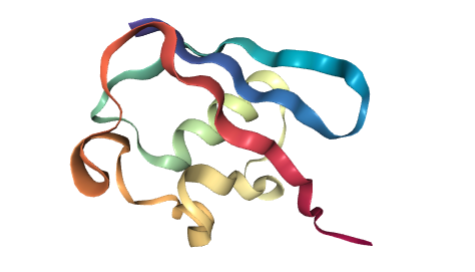

In [30]:
from IPython.display import Image
Image(filename='.\\Images\\output.png')

In [15]:
pdb = PDBFile(".\\PDB Files\\1ubq.pdb")
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')

modeller = Modeller(pdb.topology, pdb.positions)
print(modeller.topology)
modeller.addHydrogens(forcefield)
print(modeller.topology)
modeller.addSolvent(forcefield)
print(modeller.topology)

<Topology; 2 chains, 134 residues, 660 atoms, 608 bonds>
<Topology; 2 chains, 134 residues, 1405 atoms, 1353 bonds>
<Topology; 3 chains, 1502 residues, 5509 atoms, 4089 bonds>


In [18]:
unmatched = forcefield.getUnmatchedResidues(pdb.topology)

In [22]:
# MD Simulation
system = forcefield.createSystem(modeller.topology, implicitSolvent=OBC2,
                              nonbondedMethod=NoCutoff, nonbondedCutoff=1*nanometer,
                              constraints=HBonds)

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()
simulation.reporters.append(PDBReporter('.\\PDB Files\\Output\\output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(10000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-67087.078125,256.98348697051705
2000,-63974.140625,289.2480081250786
3000,-63755.125,301.6182178553418
4000,-63924.5546875,296.5305918744653
5000,-63707.65625,301.51250726866635
6000,-64285.390625,292.7764960188714
7000,-64078.5703125,298.8111405857978
8000,-63747.046875,296.6262445653699
9000,-64486.17578125,297.48838352947155
10000,-64190.73046875,303.8122083538251
